<a href="https://colab.research.google.com/github/Konerusudhir/machine_learning_exercises/blob/master/MaliciousURLDetector2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malicious URL Detection
---
Goal of this Notebook is to build 4 models using Tensorflow for Malicious URL *detection*. 4 Models are used to compare performance across different Model architectures.

Dataset for this problem is from [Kaggle](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)

This problem is solved using 4 different Models.
1. Random Forest
2. Gradient Boosted Trees
3. Single Layer Neural Network
4. Transfer learrning


In [1]:
%%capture
# Installs
!pip install tld
!pip install tensorflow tensorflow_decision_forests
%load_ext tensorboard
# !pip install tensorflow-addons
# !pip install tensorflow-model-analysis

In [2]:
import os
import re
import requests
import tarfile
from os import path
from datetime import datetime
import shutil

from IPython.display import Image

# Data handling libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# URL libs
from tld import get_tld, is_tld
from urllib.parse import urlparse

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_hub as hub
import tensorboard

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Directory Clean up

In [3]:
logs_dir = "logs"
models_dir = "trained_models"
model_imaages = "model_imaages"

def clean_directories():
  shutil.rmtree(logs_dir, ignore_errors=True)
  shutil.rmtree(models_dir, ignore_errors=True)
  shutil.rmtree(model_imaages, ignore_errors=True)
clean_directories()  

def create_directories():
  os.mkdir(model_imaages)

def get_logs_dir(model_name):
  run_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  return f"{logs_dir}/{model_name}/{run_timestamp}"

# Dowload Data File

In [4]:
url = 'https://drive.google.com/file/d/1OzJbRtgU-Z80iL7GodIH8-ymKq58g7Az/view?usp=share_link'
url_download_path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
download_file = "malicious_phish.csv"
if not path.exists(download_file):
  r = requests.get(url_download_path, allow_redirects=True)
  open(download_file, 'wb').write(r.content)
df = pd.read_csv(download_file)
# df = df.sample(n=100000, random_state=2)
df.info()
df.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


,url,type
458860,http://www.hnasdelhuerto.org.py/wp-content/plu...,phishing
193569,movies.nytimes.com/2011/02/25/movies/25heart.html,benign
456691,asinah.net/en/hotelfactsheet/3783-Hotel+Queen+...,benign
191504,l1ftdigital.com,phishing
260114,en.wikipedia.org/wiki/Joe_Bowman_(marksman),benign
331730,ncaa.com/championships/basketball-women/d1,benign
412620,serviceorange2018.godaddysites.com,phishing
363286,factbites.com/topics/Laurence-Owen,benign
563410,update.source-usernet-876j1l6opz565520db1f8e26...,benign
183352,nleomf.blogspot.com/2009_03_01_archive.html,benign


# Download Trained Model

In [5]:
MODEL_URL = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2?tf-hub-format=compressed"
TAR_FILE_PATH = 'Wiki-words-250-with-normalization.tar.gz'
DIRPATH = 'Wiki-words-250-with-normalization'

if not path.exists(TAR_FILE_PATH):
  with requests.get(MODEL_URL, allow_redirects=True) as r:
    with open(TAR_FILE_PATH, 'wb') as z:
      z.write(r.content)

if not path.exists(DIRPATH):
 with tarfile.open(TAR_FILE_PATH, 'r') as tar_ref:
   tar_ref.extractall(f"./{DIRPATH}")

hub_layer = hub.KerasLayer(
    DIRPATH,
    output_shape=[250],  # Outputs a tensor with shape [batch_size, 20].
    input_shape=[],     # Expects a tensor of shape [batch_size] as input.
    dtype=tf.string) 
print(hub_layer)

In [6]:
df.isnull().sum()

url     0
type    0
dtype: int64

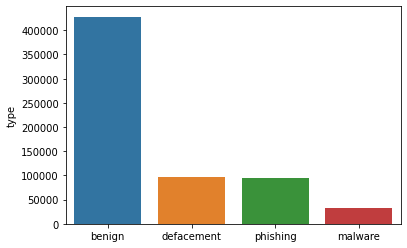

In [7]:
counts = df['type'].value_counts()
sns.barplot(x=counts.index, y=counts)

# Feature Extraction

In [8]:
df['url_len'] = df['url'].apply(lambda x: len(str(x))) 
df['count_www'] = df['url'].apply(lambda i: i.count('www'))
df['count_at'] = df['url'].apply(lambda i: i.count('@'))
df['count_dir'] = df['url'].apply(lambda url: urlparse(url).path.count('/'))
df['count_https'] = df['url'].apply(lambda i : i.count('https'))
df['count_http'] = df['url'].apply(lambda i : i.count('http'))
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

# Character counts
df['count_percent'] = df['url'].apply(lambda i: i.count('%'))
df['count_hyphen'] = df['url'].apply(lambda i: i.count('-'))

# Query parameters features
df['count_question_mark'] = df['url'].apply(lambda i: i.count('?'))
df['count_equals'] = df['url'].apply(lambda i: i.count('='))

df.sample(n=100)

,url,type,url_len,count_www,count_at,count_dir,count_https,count_http,hostname_length,count_percent,count_hyphen,count_question_mark,count_equals
18390,http://wijzijnnietgevaarlijk.nl/baasjes/search...,defacement,58,0,0,3,0,1,24,0,0,0,0
196316,lifewiththenichols.blogspot.com/,benign,32,0,0,1,0,0,0,0,0,0,0
137955,tribalpages.com/tribe/familytree?uid=seduff&su...,benign,63,0,0,2,0,0,0,0,0,1,2
366676,acronymfinder.com/Soci%c3%a9t%c3%a9-Canadienne...,benign,93,0,0,1,0,0,0,4,7,0,0
389077,diccionario.sensagent.com/joseph+signay/en-en/,benign,46,0,0,3,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22221,wikinfo.org/index.php/Democratic_Party_(United...,benign,54,0,0,2,0,0,0,0,0,0,0
348119,3206millsview.com/,benign,18,0,0,1,0,0,0,0,0,0,0
74057,myspace.com/johnbethune,benign,23,0,0,1,0,0,0,0,0,0,0
610893,groups.yahoo.com/group/Tower-pro/,phishing,33,0,0,3,0,0,0,0,1,0,0


In [9]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
df['use_of_ip'].value_counts()

0    643898
1      7293
Name: use_of_ip, dtype: int64

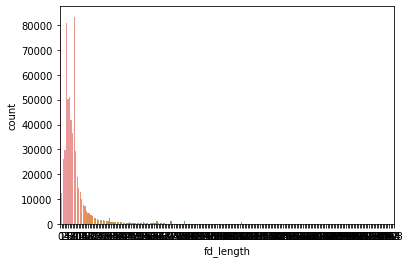

In [10]:
#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))   
sns.countplot(x='fd_length', data=df)

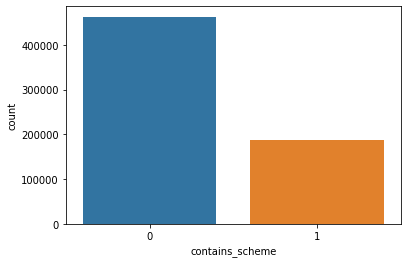

In [11]:
# Hostname extraction
def contains_scheme(url):
    scheme = urlparse(url).scheme
    scheme = scheme.strip()
    if len(scheme) > 0:
        # print(match.group())        
        return 1
    else:
        # print 'No matching pattern found'
        return 0

df['contains_scheme'] = df['url'].apply(lambda i: contains_scheme(i))

sns.countplot(x='contains_scheme', data=df)

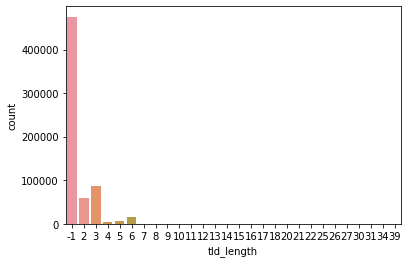

In [12]:
def get_tld_length(i):
    try:
        return len(get_tld(i,fail_silently=True))
    except:
        return -1
df['tld_length'] = df['url'].apply(lambda i: get_tld_length(i))
sns.countplot(x='tld_length', data=df)

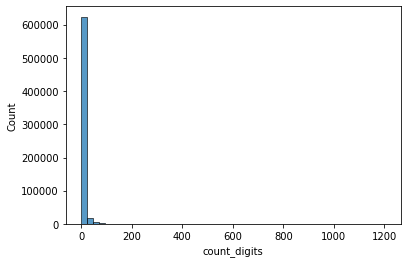

In [13]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count_digits']= df['url'].apply(lambda i: digit_count(i))
sns.histplot(x='count_digits', data=df, bins=50)

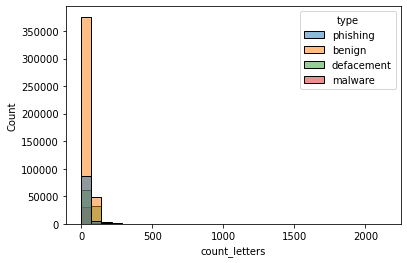

In [14]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count_letters']= df['url'].apply(lambda i: letter_count(i))
sns.histplot(x='count_letters', hue="type", data=df, bins=30)

In [15]:
def get_words(url):
  # print(url)
  # print(url[0])
  words = re.split(',|_|-|!|:|/|&|=|\?|\.', url)
  words = list(filter(lambda word: len(word.strip()) >= 2, words))
  words = [item.lower() for item in words]
  return " ".join(words)
  
df['url_words'] = df['url'].apply(lambda i: get_words(i))


.  BENIGN WordCloud


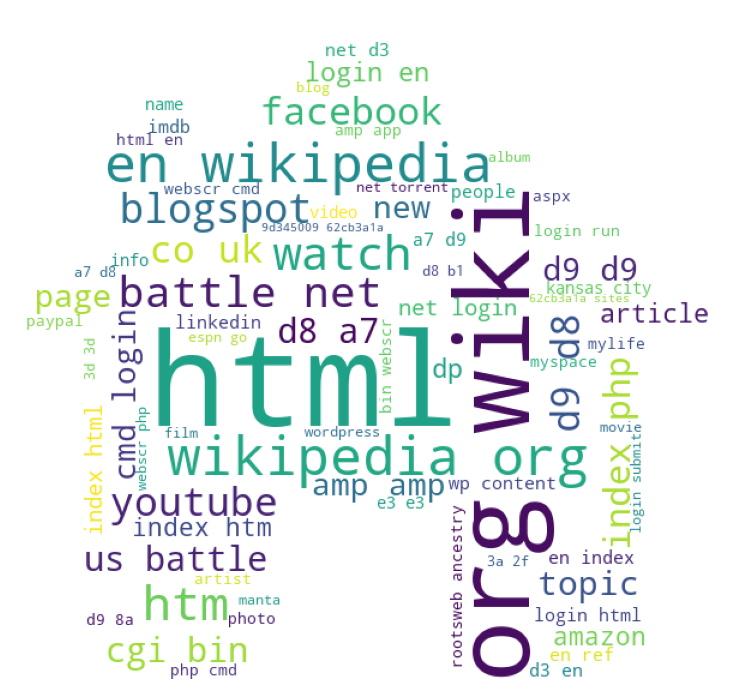


.  DEFACEMENT WordCloud


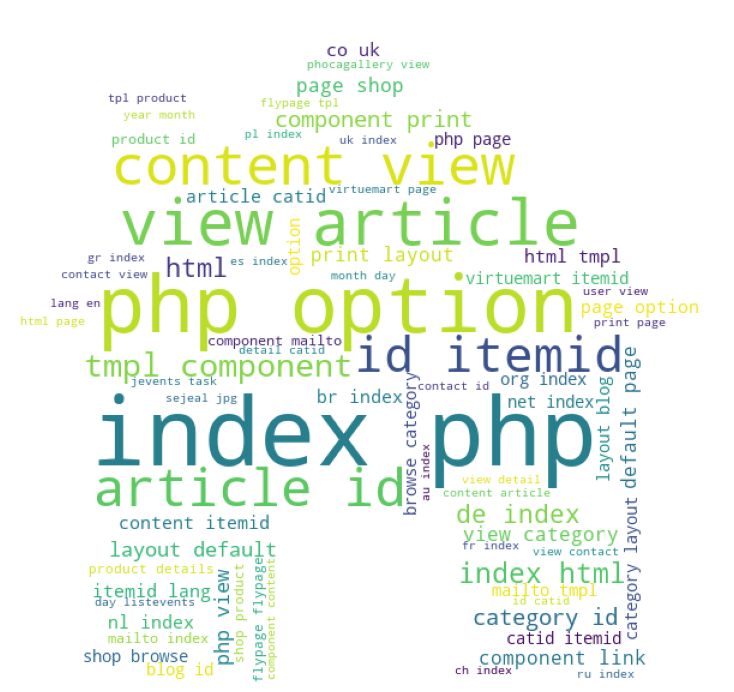


.  PHISHING WordCloud


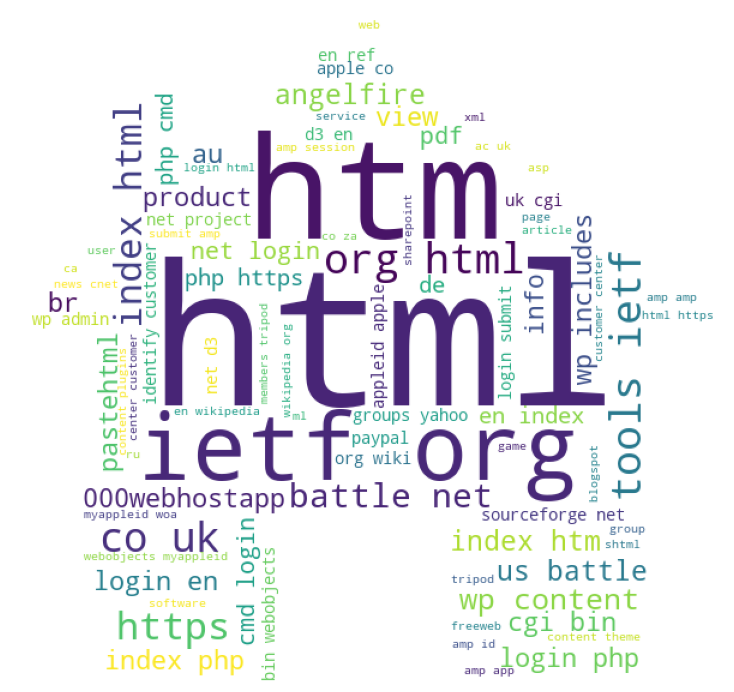


 MALWARE WordCloud


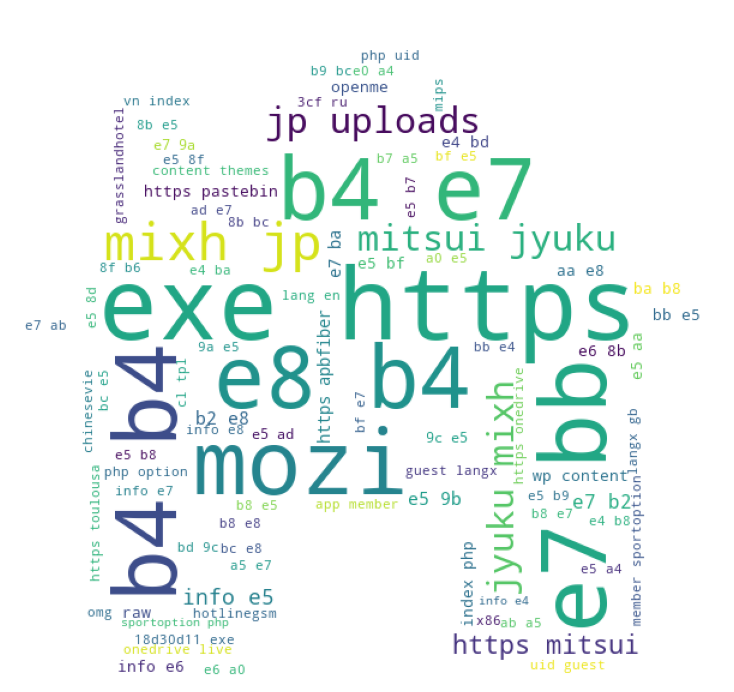

In [16]:
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image

comment_words = '' 
stopwords = set(STOPWORDS)
pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png',stream=True).raw))

def display_words(words_column, type_name):
  words = ""
  df_column = words_column[words_column['type']==type_name]
  url_words = " ".join(df_column['url_words'].values)
  # print(url_words)
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = stopwords, mask = pic, 
                  min_font_size = 10).generate(url_words)
  plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue') 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show()

words_column = df[['url_words', 'type']] 
print('\n.  BENIGN WordCloud')
display_words(words_column, 'benign')
print('\n.  DEFACEMENT WordCloud')
display_words(words_column, 'defacement')
print('\n.  PHISHING WordCloud')
display_words(words_column, 'phishing')
print('\n MALWARE WordCloud')
display_words(words_column, 'malware')


In [17]:
df.sample(n=100)

,url,type,url_len,count_www,count_at,count_dir,count_https,count_http,hostname_length,count_percent,count_hyphen,count_question_mark,count_equals,use_of_ip,fd_length,contains_scheme,tld_length,count_digits,count_letters,url_words
295093,http://kenh14.vn/sport/hoc-tro-cua-hlv-wenger-...,benign,109,0,0,2,0,1,9,0,14,0,0,0,5,1,2,19,69,http kenh14 vn sport hoc tro cua hlv wenger se...
628004,pleac.sourceforge.net/pleac_ada/t1.html,phishing,39,0,0,2,0,0,0,0,0,0,0,0,9,0,-1,1,32,pleac sourceforge net pleac ada t1 html
25508,msn.foxsports.com/nhl/player/max-pacioretty/55...,benign,50,0,0,4,0,0,0,0,1,0,0,0,3,0,-1,6,37,msn foxsports com nhl player max pacioretty 55...
115594,attsavage.com/,benign,14,0,0,1,0,0,0,0,0,0,0,0,0,0,-1,0,12,attsavage com
599717,bearben.com/KXgbf8OPLMo/webscrprim.php?YmVhcmJ...,benign,106,0,0,2,0,0,0,0,0,1,3,0,11,0,-1,21,77,bearben com kxgbf8oplmo webscrprim php ymvhcmj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537375,http://45.77.193.6/Xerified.sh,malware,30,0,0,1,0,1,11,0,0,0,0,1,11,1,-1,8,14,http 45 77 193 xerified sh
227680,http://bdnews24.com/world/2015/05/12/iran-stre...,benign,94,0,0,5,0,1,12,0,9,0,0,0,5,1,3,10,66,http bdnews24 com world 2015 05 12 iran stress...
351688,niabetty.com,phishing,12,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,11,niabetty com
572023,'1366884.com/bubblesdesu/review/account/loges/...,benign,244,0,0,14,0,0,0,1,1,1,2,0,11,0,-1,75,143,'1366884 com bubblesdesu review account loges ...


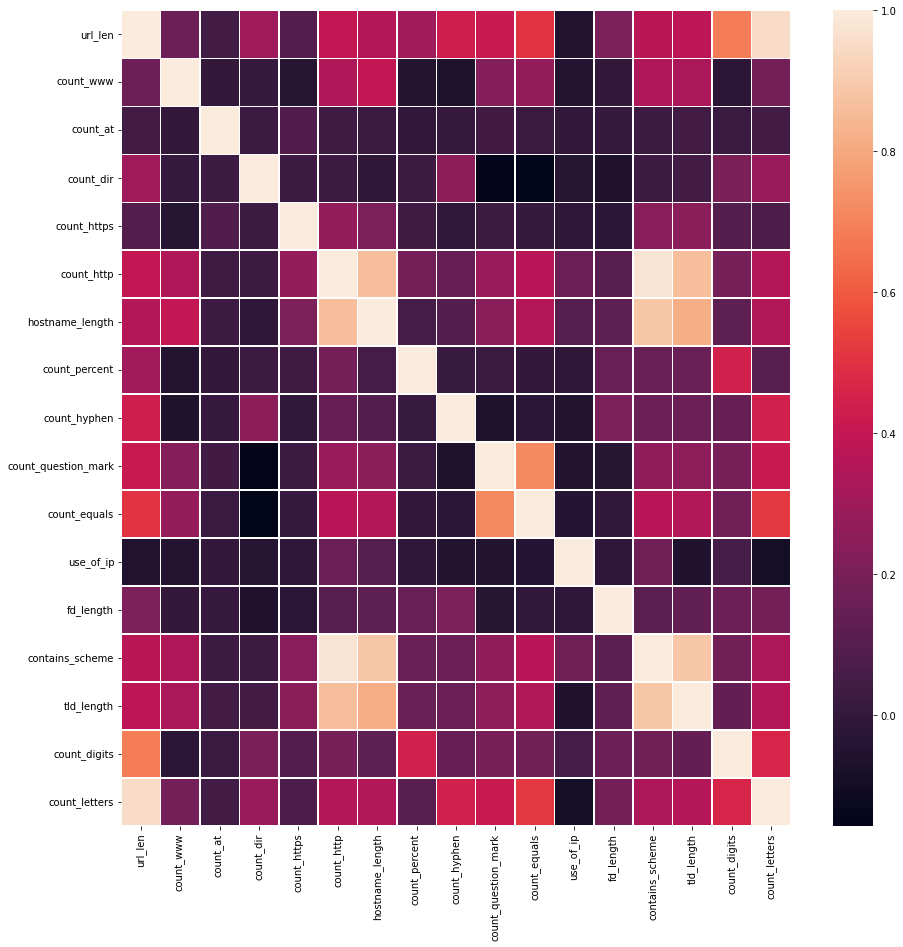

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), linewidths=.5)

In [19]:
class_names = ["benign",'defacement','phishing', 'malware']
rem = {"class": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['class'] = df['type']
df = df.replace(rem)
# df['class'] = df['class'].apply(lambda i: tf.keras.utils.to_categorical(i, num_classes=4))
# y = tf.keras.utils.to_categorical(df['class'], num_classes=4)

df.head()

,url,type,url_len,count_www,count_at,count_dir,count_https,count_http,hostname_length,count_percent,...,count_question_mark,count_equals,use_of_ip,fd_length,contains_scheme,tld_length,count_digits,count_letters,url_words,class
0,br-icloud.com.br,phishing,16,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,13,br icloud com br,2
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,2,0,0,0,0,...,0,0,0,5,0,-1,1,29,mp3raid com music krizz kaliko html,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,3,0,0,0,0,...,0,0,0,7,0,-1,1,25,bopsecrets org rexroth cr htm,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,1,0,1,0,1,21,0,...,1,4,0,9,1,2,7,63,http www garage pirenne be index php option co...,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,0,1,0,1,23,0,...,1,3,0,9,1,3,22,199,http adventure nicaragua net index php option ...,1


# Train Test Split

In [20]:
train_size = int(0.8*len(df.index))
val_size = int(0.1*len(df.index))

train_split_df, test_split_df = train_test_split(
    df, test_size=0.2, random_state=1, shuffle=True)
# train_df, val_df, train_df = np.split(df, [train_size, train_size+val_size])

print(len(train_split_df.index))
# print(len(val_df.index))
print(len(test_split_df.index))

NN_EPOCHS = 20
PATIENCE = 5

520952
130239


# Random Forest Model

In [21]:
def train_and_get_random_forest_model():
  
  train_df = train_split_df.drop(['url_words','url','type'],axis=1)
  test_df = test_split_df.drop(['url_words','url','type'],axis=1)
  
  # Convert the dataset into a TensorFlow dataset.
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="class")
  val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="class")
  
  model = tfdf.keras.RandomForestModel()
  model_metrics = [
      "accuracy"
  ]
  model.compile(metrics=model_metrics)

  # Define the Keras TensorBoard callback.
  logdir=get_logs_dir("random_forest")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

  model.fit(
      train_ds, 
      validation_data=val_ds,
      callbacks=[tensorboard_callback])
  
  return model


# Gradient Boosted Trees Model

In [22]:
def train_and_get_boosted_trees_model():

  train_df = train_split_df.drop(['url_words','url','type'],axis=1)
  test_df = test_split_df.drop(['url_words','url','type'],axis=1)
  
  # Convert the dataset into a TensorFlow dataset.
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="class")
  val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="class")

  model = tfdf.keras.GradientBoostedTreesModel()
  model_metrics = [
      "accuracy"
  ]
  model.compile(metrics=model_metrics)

  # Define the Keras TensorBoard callback.
  logdir=get_logs_dir("boosted_trees")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

  model.fit(
      train_ds, 
      validation_data=val_ds,
      callbacks=[tensorboard_callback])
  return model

# Neural Network Model

In [23]:
from IPython.display import Image, display
def save_and_display_model(model_instance):
  run_timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  img_file = f'{model_imaages}/{run_timestamp}.png'
  tf.keras.utils.plot_model(
      model_instance, 
      to_file=img_file, 
      show_dtype=True,
      show_shapes=True, 
      show_layer_names=True,
      show_layer_activations=True,
      dpi=100,
      rankdir='LB'
      )
  display(Image(img_file))

def train_and_get_neural_network_model():

  # train_shuffled_df = train_split_df.sample(frac=1, random_state=2).reset_index()
  # Convert the dataset into a TensorFlow dataset.
  train_df = train_split_df.drop(['url','type'],axis=1)
  test_df = test_split_df.drop(['url','type'],axis=1)
  
  # Convert the dataset into a TensorFlow dataset.
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="class")
  val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="class")

  # print(train_df.columns)
  column_names = train_split_df.drop(labels = ['url_words', 'url','type', 'class'], axis=1)

  def create_model():
    real_valued_columns = [
        tf.feature_column.numeric_column(key, shape=())
        for key in column_names
    ]
    # print(real_valued_columns)
    
    input_layers = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype=tf.float32)
        for colname in column_names
    }
    # print(input_layers)
    dense_features_layer = tf.keras.layers.DenseFeatures(real_valued_columns)(input_layers)
    # # Model
    output = tf.keras.layers.Dense(4, activation='softmax')(dense_features_layer)
    model_instance = tf.keras.Model(input_layers, output)

    # Compile and fit
    metrics = [
        "accuracy"
    ]
    model_instance.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=metrics
        )
    
    return model_instance
  
  model = create_model()
  # Define the Keras TensorBoard callback.
  logdir=get_logs_dir("neural_network_transfer_learning")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
  weights_file = models_dir+"/best_weights"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weights_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)
  
  model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=NN_EPOCHS,
      callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback])
  
  best_model = create_model()
  best_model.load_weights(weights_file)
  return best_model

# Neural Network with Transfer Learning Model

In [24]:
def train_and_get_neural_network_transfer_learning_model():

  # train_shuffled_df = train_split_df.sample(frac=1, random_state=2).reset_index()
  # Convert the dataset into a TensorFlow dataset.
  train_df = train_split_df.drop(['url','type'],axis=1)
  test_df = test_split_df.drop(['url','type'],axis=1)
  
  # Convert the dataset into a TensorFlow dataset.
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="class")
  val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="class")

  # print(train_df.columns)
  column_names = train_split_df.drop(labels = ['url_words', 'url','type', 'class'], axis=1)

  def create_model():
    real_valued_columns = [
        tf.feature_column.numeric_column(key, shape=())
        for key in column_names
    ]
    # print(real_valued_columns)
    
    input_layers = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype=tf.float32)
        for colname in column_names
    }
    # print(input_layers)
    dense_features_layer = tf.keras.layers.DenseFeatures(real_valued_columns)(input_layers)

    # Embeddings
    url_words_input = tf.keras.Input(name='url_words', shape=tf.shape(''), dtype=tf.string)
    input_layers.update({
          "url_words": url_words_input   
    })
    # print(hub_layer)
    embedding_layer = hub_layer(url_words_input)

    # # Concatenation
    # # input_layers['url_words'] = embedding_input_layer
    all_feature_layers = tf.keras.layers.concatenate([dense_features_layer, embedding_layer])

    # # Model
    output = tf.keras.layers.Dense(4, activation='softmax')(all_feature_layers)
    model_instance = tf.keras.Model(input_layers, output)

    # Compile and fit
    metrics = [
        "accuracy",
        # tf.keras.metrics.AUC(num_thresholds=3)
    ]
    model_instance.compile(
        optimizer=tf.keras.optimizers.SGD(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=metrics
        )
    
    return model_instance
  
  model = create_model()
  # Define the Keras TensorBoard callback.
  logdir=get_logs_dir("neural_network")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
  weights_file = models_dir+"/best_weights"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weights_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)
  
  model.fit(
      train_ds, 
      validation_data=val_ds,
      epochs=NN_EPOCHS,
      callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback])
  
  best_model = create_model()
  best_model.load_weights(weights_file)
  return best_model


# Training All Models

In [ ]:
clean_directories() 
create_directories()

model_functions = [
    train_and_get_random_forest_model, 
    train_and_get_boosted_trees_model,
    train_and_get_neural_network_model,
    train_and_get_neural_network_transfer_learning_model
]

trained_models = []
for model_function in model_functions:
  model = model_function()
  trained_models.append(model)
  

Use /tmp/tmpk4kyskmw as temporary training directory
Reading training dataset...


/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


Training dataset read in 0:00:09.353420. Found 520952 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(130239, shape=(), dtype=int32)
Validation dataset read in 0:00:01.992115. Found 130239 examples.
Training model...
Model trained in 0:08:50.914167
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Use /tmp/tmp58_tu1rf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.288824. Found 520952 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(130239, shape=(), dtype=int32)
Validation dataset read in 0:00:05.150617. Found 130239 examples.
Training model...


In [ ]:
for model in trained_models:
  test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_split_df, label="class")
  model_metrics = model.evaluate(test_ds)
  results = model.predict(test_ds)
  predictions = pd.DataFrame(results)
  predictions['class'] = predictions.apply(lambda row : np.argmax(row), axis = 1)
  cf_matrix = metrics.confusion_matrix(test_split_df["class"], predictions['class'])

  print(f"\n\n Model: {model.__class__.__name__}") 
  print(f"\n Accuracy: {model_metrics[1]}    Loss: {model_metrics[0]} \n")

  print('\n Confusion_matrix \n')
  plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
  plt.show()

  print('\n Classification_report \n')
  print(metrics.classification_report(test_split_df["class"], predictions['class'], digits=3))
  if model.__class__.__name__ != 'Functional':
    display(tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3))
  else:
    save_and_display_model(model)  

In [ ]:
%tensorboard --logdir logs